# Positional Validation


In [1]:
# ruff: noqa: E402

%load_ext autoreload
%autoreload 2

# find the root of the project
import os
from pathlib import Path
import sys
import polars as pl

ROOT = Path(os.getcwd()).parent
while not ROOT.joinpath(".git").exists():
    ROOT = ROOT.parent

# add the root to the python path
sys.path.append(str(ROOT))

## Read the Data


In [2]:
veh_df = (
    pl.read_csv(
        ROOT / "data" / "vehicle_drives" / "2023-10-31.csv",
    )
    .drop("")
    .with_columns(
        pl.col("gps_time").str.strptime(
            dtype=pl.Datetime(
                time_unit="us",
            ),
        ),
    )
    .sort(
        "gps_time",
    )
    # .upsample(
    #     "gps_time",
    #     every="100ms",
    # )
    # .sort("gps_time")
    # .with_columns(
    #     pl.col(pl.FLOAT_DTYPES).interpolate(),
    #     pl.col(pl.INTEGER_DTYPES).first(),
    # )
    .with_row_count(name="seq")
)

In [3]:
veh_df.shape

(19612, 5)

### Map to Lanes


In [4]:
import geopandas as gpd
from src.geometry import RoadNetwork


network = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
)

lane_df = network.df

## Snap the Vehicle Trajectories to Lanes


In [5]:
import utm

x, y, _, _ = utm.from_latlon(
    latitude=veh_df["lat"].to_numpy(),
    longitude=veh_df["lon"].to_numpy(),
)

veh_df = (
    veh_df.with_columns(
        x=x,
        y=y,
    )
    .with_columns(
        (pl.col("x").diff() ** 2 + pl.col("y").diff() ** 2).sqrt().alias("dist"),
    )
    .with_columns(
        (
            pl.col("dist") / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
        ).alias("speed"),
    )
)

veh_df.head()

shape: (5, 9)
┌─────┬───────────────┬───────────┬────────────┬───┬──────────────┬──────────┬──────────┬──────────┐
│ seq ┆ gps_time      ┆ lat       ┆ lon        ┆ … ┆ x            ┆ y        ┆ dist     ┆ speed    │
│ --- ┆ ---           ┆ ---       ┆ ---        ┆   ┆ ---          ┆ ---      ┆ ---      ┆ ---      │
│ u32 ┆ datetime[μs,  ┆ f64       ┆ f64        ┆   ┆ f64          ┆ f64      ┆ f64      ┆ f64      │
│     ┆ UTC]          ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
╞═════╪═══════════════╪═══════════╪════════════╪═══╪══════════════╪══════════╪══════════╪══════════╡
│ 0   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97831 ┆ 3.6775e6 ┆ null     ┆ null     │
│     ┆ 16:43:11.400  ┆           ┆            ┆   ┆ 5            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 1   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97869 ┆ 3.6775e6 ┆ 0.000962 ┆ 0.009621 │
│     ┆ 16:43:11.500  ┆           ┆            ┆   ┆ 2            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 2   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97924 ┆ 3.6775e6 ┆ 0.000787 ┆ 0.007873 │
│     ┆ 16:43:11.600  ┆           ┆            ┆   ┆ 8            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 3   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97850 ┆ 3.6775e6 ┆ 0.000816 ┆ 0.008162 │
│     ┆ 16:43:11.700  ┆           ┆            ┆   ┆ 1            ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│ 4   ┆ 2023-10-31    ┆ 33.235349 ┆ -87.610211 ┆ … ┆ 443147.97897 ┆ 3.6775e6 ┆ 0.000724 ┆ 0.007241 │
│     ┆ 16:43:11.800  ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
│     ┆ UTC           ┆           ┆            ┆   ┆              ┆          ┆          ┆          │
└─────┴───────────────┴───────────┴────────────┴───┴──────────────┴──────────┴──────────┴──────────┘

### Build the KDTree


In [6]:
veh_df = network.map_to_lane(
    veh_df,
    dist_upper_bound=3,
    utm_x_col="x",
    utm_y_col="y",
)

In [7]:
veh_df = (
    veh_df.with_columns(
        pl.col("name").fill_null(""),
    )
    .with_columns(
        (
            (pl.col("name").shift(1) != pl.col("name"))
            & (pl.col("name").shift(1) != "")
        ).alias("sequence"),
    )
    .with_columns(
        (pl.col("sequence").cum_sum() * (pl.col("name") != "")).alias("sequence_id"),
    )
    .filter(pl.col("sequence_id") != 0)
)

In [8]:
veh_df.head()

shape: (5, 18)
┌──────┬────────────────────┬───────────┬────────────┬───┬─────────┬──────┬──────────┬─────────────┐
│ seq  ┆ gps_time           ┆ lat       ┆ lon        ┆ … ┆ angle   ┆ name ┆ sequence ┆ sequence_id │
│ ---  ┆ ---                ┆ ---       ┆ ---        ┆   ┆ ---     ┆ ---  ┆ ---      ┆ ---         │
│ u32  ┆ datetime[μs, UTC]  ┆ f64       ┆ f64        ┆   ┆ f64     ┆ str  ┆ bool     ┆ u32         │
╞══════╪════════════════════╪═══════════╪════════════╪═══╪═════════╪══════╪══════════╪═════════════╡
│ 1325 ┆ 2023-10-31         ┆ 33.235712 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ true     ┆ 1           │
│      ┆ 16:45:35.200 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1326 ┆ 2023-10-31         ┆ 33.235719 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.300 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1327 ┆ 2023-10-31         ┆ 33.235726 ┆ -87.610401 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.400 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1328 ┆ 2023-10-31         ┆ 33.235734 ┆ -87.610402 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.500 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
│ 1329 ┆ 2023-10-31         ┆ 33.235741 ┆ -87.610402 ┆ … ┆ 0.26254 ┆ EBL2 ┆ false    ┆ 1           │
│      ┆ 16:45:35.600 UTC   ┆           ┆            ┆   ┆         ┆      ┆          ┆             │
└──────┴────────────────────┴───────────┴────────────┴───┴─────────┴──────┴──────────┴─────────────┘

In [9]:
ebl1_df = veh_df.filter(pl.col("sequence_id") == 12).with_columns(
    (
        pl.col("s").diff() / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
    ).alias("speed")
)

In [10]:
ebl1_df.head()

shape: (5, 18)
┌──────┬──────────────────┬───────────┬────────────┬───┬───────────┬──────┬──────────┬─────────────┐
│ seq  ┆ gps_time         ┆ lat       ┆ lon        ┆ … ┆ angle     ┆ name ┆ sequence ┆ sequence_id │
│ ---  ┆ ---              ┆ ---       ┆ ---        ┆   ┆ ---       ┆ ---  ┆ ---      ┆ ---         │
│ u32  ┆ datetime[μs,     ┆ f64       ┆ f64        ┆   ┆ f64       ┆ str  ┆ bool     ┆ u32         │
│      ┆ UTC]             ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
╞══════╪══════════════════╪═══════════╪════════════╪═══╪═══════════╪══════╪══════════╪═════════════╡
│ 8562 ┆ 2023-10-31       ┆ 33.234887 ┆ -87.614469 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.600 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8563 ┆ 2023-10-31       ┆ 33.234893 ┆ -87.614466 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.700 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8564 ┆ 2023-10-31       ┆ 33.234898 ┆ -87.614463 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.800 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8565 ┆ 2023-10-31       ┆ 33.234903 ┆ -87.614461 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:46.900 UTC ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
│ 8566 ┆ 2023-10-31       ┆ 33.234908 ┆ -87.614459 ┆ … ┆ -2.879562 ┆ WBL2 ┆ false    ┆ 12          │
│      ┆ 16:58:47 UTC     ┆           ┆            ┆   ┆           ┆      ┆          ┆             │
└──────┴──────────────────┴───────────┴────────────┴───┴───────────┴──────┴──────────┴─────────────┘

## Read in the Trajectories


In [11]:
from datetime import timedelta
import polars as pl
from src.radar import CalibratedRadar
from src.pipelines.open_file import prep_df


# make a consolidated network with only EBL1 and WBL1

mainline_net = RoadNetwork(
    lane_gdf=gpd.read_file(ROOT / "data/mainline_lanes.geojson"),
    keep_lanes=["EBL1", "WBL1"],
)

radar_obj = CalibratedRadar(
    radar_location_path=ROOT / "configuration" / "october_calibrated.yaml",
)


radar_df = (
    pl.scan_parquet(
        ROOT.joinpath("data", "raw", "*.parquet"),
    )
    .with_columns(
        pl.col("epoch_time").dt.replace_time_zone("UTC"),
    )
    .with_context(veh_df.lazy())
    .filter(
        pl.col("epoch_time").is_between(
            pl.col("gps_time").min() - timedelta(seconds=30),
            pl.col("gps_time").max() + timedelta(seconds=30),
        )
    )
    # .filter(pl.col("ip").str.split(".").list.last().is_in(["146", "147", "142"]))
    .collect()
    .lazy()
    .pipe(prep_df, f=radar_obj)
    # .filter(pl.col("ip").str.contains("146")
    # .collect()
    .pipe(
        mainline_net.map_to_lane,
        dist_upper_bound=10,
        utm_x_col="utm_x",
        utm_y_col="utm_y",
    )
    .filter(pl.col("name").is_not_null())
    .rename({"name": "lane"})
)

function: create_object_id took: 0.0016009807586669922 seconds
function: filter_short_trajectories took: 0.0017271041870117188 seconds
function: clip_trajectory_end took: 0.0002980232238769531 seconds
function: resample took: 0.0005540847778320312 seconds
function: fix_duplicate_positions took: 8.58306884765625e-05 seconds
function: set_timezone took: 3.314018249511719e-05 seconds
function: add_cst_timezone took: 1.9073486328125e-05 seconds
function: add_heading took: 0.00015211105346679688 seconds
function: rotate_radars took: 0.0003437995910644531 seconds
function: update_origin took: 0.00010371208190917969 seconds


In [12]:
# radar_df.filter(
#     pl.col('object_id') == 3631321283062933221
# )

In [13]:
from src.pipelines.kalman_filter import (
    prepare_frenet_measurement,
    build_extension,
    add_timedelta,
    build_kalman_id,
    filter_short_trajectories,
)

radar_df = (
    radar_df.rename(
        {
            "angle": "heading_lane",
        }
    )
    .pipe(filter_short_trajectories, minimum_distance_m=10, minimum_duration_s=2)
    .pipe(prepare_frenet_measurement)
    .pipe(build_extension)
    .pipe(add_timedelta)
    .pipe(build_kalman_id)
    .collect()
)

function: filter_short_trajectories took: 0.06449508666992188 seconds
function: prepare_frenet_measurement took: 0.00027489662170410156 seconds
function: build_extension took: 0.6444170475006104 seconds
function: add_timedelta took: 0.00011014938354492188 seconds
function: build_kalman_id took: 0.00021886825561523438 seconds


In [14]:
radar_df.filter(
    (pl.col("epoch_time") - pl.col("epoch_time").min()).dt.total_minutes() < 2
).pipe(
    radar_obj.radar_to_latlon,
    utm_x_col="x_lane",
    utm_y_col="y_lane",
    lat_col="lat_lane",
    lon_col="lon_lane",
).select(
    ["object_id", "epoch_time", "lat", "lon", "lat_lane", "lon_lane", "ip"]
).write_csv(
    ROOT / "data" / "radar_lane.csv"
)

function: radar_to_latlon took: 0.011099100112915039 seconds


In [15]:
radar_df[["s", "s_velocity", "d", "d_velocity"]].describe()

shape: (9, 5)
┌────────────┬─────────────┬────────────┬───────────┬────────────┐
│ describe   ┆ s           ┆ s_velocity ┆ d         ┆ d_velocity │
│ ---        ┆ ---         ┆ ---        ┆ ---       ┆ ---        │
│ str        ┆ f64         ┆ f64        ┆ f64       ┆ f64        │
╞════════════╪═════════════╪════════════╪═══════════╪════════════╡
│ count      ┆ 1.12764e6   ┆ 1.12764e6  ┆ 1.12764e6 ┆ 1.12764e6  │
│ null_count ┆ 0.0         ┆ 0.0        ┆ 0.0       ┆ 0.0        │
│ mean       ┆ 864.273628  ┆ 13.99848   ┆ 1.536991  ┆ -0.140127  │
│ std        ┆ 335.258513  ┆ 7.580779   ┆ 3.528379  ┆ 0.654485   │
│ min        ┆ 20.700023   ┆ 0.0        ┆ -9.997848 ┆ -7.586312  │
│ 25%        ┆ 573.900636  ┆ 8.391951   ┆ -0.35244  ┆ -0.344419  │
│ 50%        ┆ 843.194008  ┆ 15.519548  ┆ 1.017813  ┆ -0.045137  │
│ 75%        ┆ 1165.501293 ┆ 19.942905  ┆ 3.844543  ┆ 0.137446   │
│ max        ┆ 1693.401878 ┆ 34.049948  ┆ 9.999982  ┆ 5.606703   │
└────────────┴─────────────┴────────────┴───────────┴────────────┘

In [16]:
from src.pipelines.kalman_filter import build_kalman_df

filter_df = radar_df.pipe(build_kalman_df).collect()

function: build_kalman_df took: 0.001664876937866211 seconds


### Loop through all the Trajectories and find the Trouble Ones


In [17]:
# from src.filters.vectorized_kalman import IMMFilter, CALCFilter, CVLKFilter
# import numpy as np


# for vehicle_id in filter_df["vehicle_ind"].unique():
#     veh_df = filter_df.filter(pl.col("vehicle_ind") == vehicle_id).with_columns(
#         pl.lit(0).alias("vehicle_ind")
#     )

#     IMMFilter(
#         df=veh_df.rename({"measurement": "z"}),
#         filters=("CALC", "CALK", "CVLK"),
#         M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
#         mu=np.array([0.05, 0.3, 0.65]),
#         gpu=False,
#     ).apply_filter()

In [18]:
# radar_df.filter(pl.col("kalman_id") == veh_df["kalman_id"][0])

### IMM Filter the Radar Trajectories


In [19]:
from src.filters.vectorized_kalman import batch_imm_df
import numpy as np

filt_df = batch_imm_df(
    filter_df.rename({"measurement": "z"}),
    filters=("CALC", "CALK", "CVLK"),
    M=np.array([[0.8, 0.1, 0.1], [0.1, 0.8, 0.1], [0.1, 0.1, 0.8]]),
    mu=np.array([0.05, 0.3, 0.65]),
    # chunk_size=3_500,
    chunk_size=800,
    gpu=False,
)

100%|██████████| 9/9 [00:47<00:00,  5.24s/it]


In [20]:
from src.pipelines.kalman_filter import join_results

joined_df = join_results(filt_df, filter_df, radar_df).collect()

function: join_results took: 0.052468061447143555 seconds


## Plotting the Lanes


<Axes: ylabel='Frequency'>

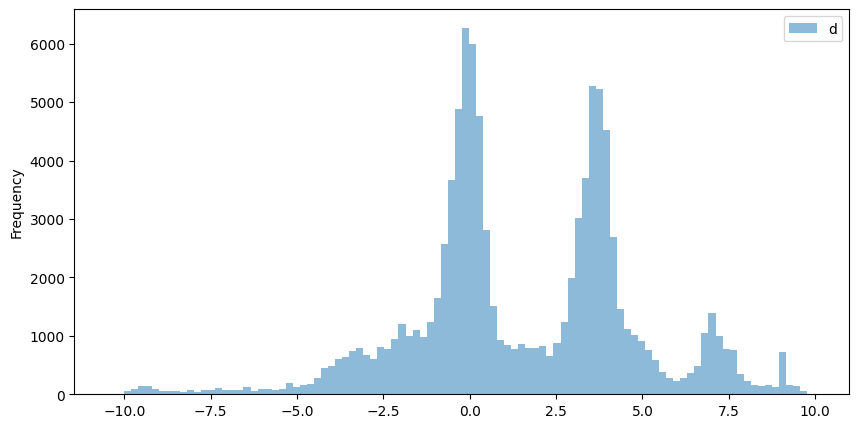

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

joined_df.filter(pl.col("lane").str.contains("W"))[["d"]].sample(
    100_000
).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

# set the range of the x-axis to be the same
# ax.set_xlim(-6, 10)
# radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

<Axes: ylabel='Frequency'>

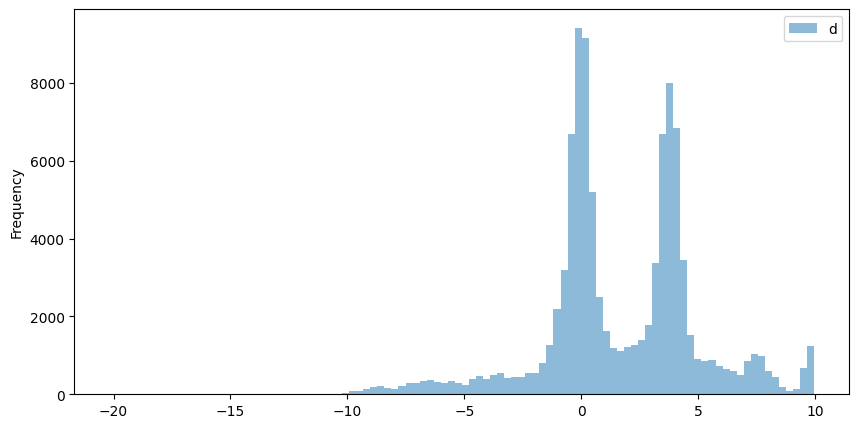

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

joined_df.filter(pl.col("lane").str.contains("E"))[["d"]].sample(
    100_000
).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

# set the range of the x-axis to be the same
# ax.set_xlim(-6, 10)
# radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

### Classify the Lanes


In [23]:
from src.pipelines.lane_classification import label_lane
from src.gmm.lane_classification import build_lane_model
from src.plotting.lane_gmm import plot_model

In [24]:
joined_df = joined_df.pipe(label_lane, right_lane_center=0, lane_width=3.55)

function: label_lane took: 0.08363914489746094 seconds


In [25]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 5))

# laned_df.filter(pl.col("lane").str.contains("W") & pl.col('lane_index').is_not_null())[["d"]].sample(
#     100_000
# ).to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5, )

# # set the range of the x-axis to be the same
# # ax.set_xlim(-6, 10)
# # radar_df["d"].to_pandas().plot.hist(bins=100, ax=ax, alpha=0.5)

In [26]:
# eblm = build_lane_model(
#     lane_centers=[-3.5, 0, 3.5, 7],
#     train_data=joined_df.filter(
#         (pl.col("lane").str.contains("E"))
#         # & pl.col("d").is_between(-10, 10)
#         & ~pl.col('prediction')
#     )[["d"]],
#     priors=[0.05, 0.45, 0.45, 0.05],
#     variance=0.1,
# )

# fig, ax = plt.subplots(figsize=(10, 5))

# plot_model(
#     eblm,
#     ax=ax,
#     range=(-5, 8),
#     lane_names=["EBL1", "EBL2", "EBL3", "EBL4"],
# )

## Merge the Trajectories


In [27]:
from src.pipelines.association import build_leader_follower_df, add_front_back_s

lf_df = (
    joined_df.lazy()
    .pipe(add_front_back_s, use_median_length=False)
    .pipe(build_leader_follower_df)
    # only consider vehicles that are fairly close
    .filter(pl.col("s_gap") < 10)
    # don't keep matches that are both prediction
    .filter(~(pl.col("prediction") & pl.col("prediction_leader")))
    # .filter()
    # assumption that radar tracks perfectly
    # .filter(pl.col("ip") != pl.col("ip_leader"))
    .filter(pl.col("s_velocity") > 5)
    .collect()
)

function: add_front_back_s took: 7.200241088867188e-05 seconds
function: lazy_func took: 0.014495134353637695 seconds


In [28]:
lf_df.head()

shape: (5, 24)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ object_id ┆ epoch_tim ┆ lane_hash ┆ leader    ┆ … ┆ P_leader  ┆ predictio ┆ ip_leader ┆ s_gap    │
│ ---       ┆ e         ┆ ---       ┆ ---       ┆   ┆ ---       ┆ n_leader  ┆ ---       ┆ ---      │
│ u64       ┆ ---       ┆ u64       ┆ u64       ┆   ┆ array[f32 ┆ ---       ┆ str       ┆ f32      │
│           ┆ datetime[ ┆           ┆           ┆   ┆ , 36]     ┆ bool      ┆           ┆          │
│           ┆ ms, UTC]  ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [3.846154 ┆ false     ┆ 10.160.7. ┆ 4.099854 │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ , 0.0, …  ┆           ┆ 137       ┆          │
│ 7         ┆ 5.300 UTC ┆ 71        ┆ 1         ┆   ┆ 100.0]    ┆           ┆           ┆          │
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [1.962077 ┆ false     ┆ 10.160.7. ┆ 3.9104   │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ ,         ┆           ┆ 137       ┆          │
│ 7         ┆ 5.400 UTC ┆ 71        ┆ 1         ┆   ┆ 0.025363, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 4.793468] ┆           ┆           ┆          │
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [1.319231 ┆ false     ┆ 10.160.7. ┆ 4.051636 │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ ,         ┆           ┆ 137       ┆          │
│ 7         ┆ 5.500 UTC ┆ 71        ┆ 1         ┆   ┆ 0.035491, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 1.731644] ┆           ┆           ┆          │
│ 182220357 ┆ 2023-10-3 ┆ 140855276 ┆ 880544524 ┆ … ┆ [3.846154 ┆ false     ┆ 10.160.7. ┆ 8.48645  │
│ 753212756 ┆ 1 16:45:0 ┆ 355311033 ┆ 969998276 ┆   ┆ , 0.0, …  ┆           ┆ 146       ┆          │
│ 68        ┆ 5.600 UTC ┆ 17        ┆ 4         ┆   ┆ 100.0]    ┆           ┆           ┆          │
│ 283311245 ┆ 2023-10-3 ┆ 131546905 ┆ 661123734 ┆ … ┆ [0.995974 ┆ false     ┆ 10.160.7. ┆ 4.130005 │
│ 887092136 ┆ 1 16:45:0 ┆ 103251931 ┆ 052729549 ┆   ┆ ,         ┆           ┆ 137       ┆          │
│ 7         ┆ 5.600 UTC ┆ 71        ┆ 1         ┆   ┆ 0.041938, ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ …         ┆           ┆           ┆          │
│           ┆           ┆           ┆           ┆   ┆ 0.830879] ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

### Calculate the Association Log-Likelihood Distance


In [29]:
from src.pipelines.association import calc_assoc_liklihood_distance

lf_df = lf_df.pipe(
    calc_assoc_liklihood_distance,
    gpu=False,
)

function: lazy_func took: 0.8452212810516357 seconds


### Calculate the Match Indexes


In [30]:
from scipy.stats import chi
from src.pipelines.association import (
    calculate_match_indexes,
    pipe_gate_headway_calc,
    build_match_df,
)

match_df = (
    lf_df.pipe(calculate_match_indexes, match_time_threshold=0.5)
    .pipe(pipe_gate_headway_calc)
    .pipe(
        build_match_df,
        traj_time_df=joined_df.group_by("object_id")
        .agg(
            pl.col("epoch_time").max().alias("epoch_time_max"),
        )
        .lazy(),
        assoc_cutoff=chi.ppf(0.995, 4),
        assoc_cutoff_pred=chi.ppf(0.99, 4),
    )
    .collect()
)

function: lazy_func took: 0.0006320476531982422 seconds
function: lazy_func took: 8.702278137207031e-05 seconds
function: lazy_func took: 0.22692465782165527 seconds


### Re-Label the Joined Trajectories


In [31]:
from src.pipelines.association import create_vehicle_ids

assoc_df = joined_df.pipe(
    create_vehicle_ids,
    match_df,
)

function: lazy_func took: 0.8025171756744385 seconds


In [32]:
veh_df[["sequence_id", "name"]].unique().join(
    veh_df["sequence_id"].value_counts(),
    on="sequence_id",
).filter(pl.col("counts") > 100).sort(
    "counts",
)

shape: (10, 3)
┌─────────────┬──────┬────────┐
│ sequence_id ┆ name ┆ counts │
│ ---         ┆ ---  ┆ ---    │
│ u32         ┆ str  ┆ u32    │
╞═════════════╪══════╪════════╡
│ 6           ┆ EBL1 ┆ 157    │
│ 4           ┆ WBL1 ┆ 237    │
│ 10          ┆ WBL2 ┆ 379    │
│ 5           ┆ WBL1 ┆ 431    │
│ …           ┆ …    ┆ …      │
│ 22          ┆ WBL1 ┆ 999    │
│ 19          ┆ WBL2 ┆ 1061   │
│ 23          ┆ EBL2 ┆ 1199   │
│ 20          ┆ EBL1 ┆ 1242   │
└─────────────┴──────┴────────┘

In [33]:
drive_df = veh_df.filter((pl.col("sequence_id") == 20))

drive_df = drive_df.pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)
drive_df["name"][0]
# drive_df[["lat", "lon", "gps_time"]].write_csv(ROOT / "data" / "drive.csv")

function: add_cst_timezone took: 0.007052183151245117 seconds


'EBL1'

In [34]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()

fig = go.Figure()


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=max_s - seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


# get a 10 minute window
plot_df = (
    assoc_df.with_columns((max_s - pl.col("s")).alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=30),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=30),
        )
        & (pl.col("lane").str.contains("E"))
        & (pl.col("lane_index") == 0)
    )
    .pipe(radar_obj.add_cst_timezone)
    # .filter(pl.col("vehicle_id") == 886)
)

fig = plot_time_space(
    plot_df,
    hoverdata="object_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
    fig=fig,
)


fig.show()

function: add_cst_timezone took: 0.00025010108947753906 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [35]:
# from src.plotting.single_veh import plot_vehicle

# # 2370	22	2.326786	0.303536	"1"
# # 1227	22	6.57618	1.667884	"1"
# # 1209
# vehs = [
#     1286,
# ]

# fig = None

# drive_df = veh_df.filter((pl.col("sequence_id") == 22)).pipe(
#     radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
# )

# for veh in vehs:
#     fig = plot_vehicle(
#         assoc_df.filter(pl.col("vehicle_id") == veh).pipe(
#             radar_obj.add_cst_timezone,
#         ),
#         # s_velocity_col="f32_velocityInDir_mps",
#         fig=fig,
#     )

#     fig = plot_vehicle(
#         radar_df.filter(
#             pl.col("object_id").is_in(
#                 assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
#             )
#         ).pipe(
#             radar_obj.add_cst_timezone,
#         ),
#         # s_velocity_col="f32_velocityInDir_mps",
#         # d_velocity_col="f32_velocityCrossDir_mps",
#         fig=fig,
#         color="red",
#     )

# plot_vehicle(
#     drive_df.with_columns(
#         pl.col("speed").alias("s_velocity"),
#         (
#             pl.col("d").diff()
#             / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
#         ).alias("d_velocity"),
#         pl.col("gps_time") - timedelta(seconds=15.5),
#         (pl.col("d") + 3.55),
#     ).pipe(
#         radar_obj.add_cst_timezone,
#         time_col="gps_time",
#     ),
#     color="green",
#     fig=fig,
# )

# fig.update_layout(
#     height=800,
#     width=1200,
# )

## Fuse & Smooth the Trajectories


In [36]:
from src.pipelines.association import build_fusion_df

fusion_df = (
    assoc_df.pipe(build_fusion_df, speed_threshold=5)
    .collect(streaming=True)
    .pipe(
        radar_obj.add_cst_timezone,
        time_col="epoch_time",
    )
)

fusion_df.head()

function: lazy_func took: 3.7869818210601807 seconds
function: add_cst_timezone took: 0.031785011291503906 seconds


shape: (5, 63)
┌─────────────┬────────────┬─────────┬──────────┬───┬──────────┬───────┬────────────┬──────────────┐
│ s           ┆ s_velocity ┆ s_accel ┆ d        ┆ … ┆ cumcount ┆ count ┆ time_index ┆ vehicle_time │
│ ---         ┆ ---        ┆ ---     ┆ ---      ┆   ┆ ---      ┆ ---   ┆ ---        ┆ _index_int   │
│ f32         ┆ f32        ┆ f32     ┆ f32      ┆   ┆ u32      ┆ u32   ┆ u32        ┆ ---          │
│             ┆            ┆         ┆          ┆   ┆          ┆       ┆            ┆ u32          │
╞═════════════╪════════════╪═════════╪══════════╪═══╪══════════╪═══════╪════════════╪══════════════╡
│ 875.401001  ┆ 6.801968   ┆ 0.0     ┆ 4.103283 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 940.20105   ┆ 13.87649   ┆ 0.0     ┆ 3.501817 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 948.593262  ┆ 14.29954   ┆ 0.0     ┆ 0.319716 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 538.196167  ┆ 13.869459  ┆ 0.0     ┆ 3.870112 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
│ 1209.701416 ┆ 0.0        ┆ 0.0     ┆ 3.439374 ┆ … ┆ 0        ┆ 1     ┆ 0          ┆ 0            │
└─────────────┴────────────┴─────────┴──────────┴───┴──────────┴───────┴────────────┴──────────────┘

In [37]:
from src.filters.fusion import batch_join, rts_smooth

merged_df = batch_join(fusion_df, method="IMF", batch_size=200, gpu=False)
merged_df = rts_smooth(merged_df, batch_size=200, gpu=False)

# # trim the last 4 seconds of all trajectories
# merged_df = merged_df.filter(
#     ((pl.col('epoch_time').max() - pl.col('epoch_time')) > timedelta(seconds=4)).over('vehicle_id')
# )

100%|██████████| 1214/1214 [00:04<00:00, 252.40it/s]
/Users/max/Development/DOE-Project/roadside-radar/src/filters/fusion.py:633: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)

100%|██████████| 1214/1214 [00:01<00:00, 1185.72it/s]


In [38]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()


# get a 10 minute window
plot_df = (
    merged_df.with_columns(pl.col("s_smooth").alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, seconds=30),
            drive_df["gps_time"].max() + timedelta(hours=0, seconds=30),
        )
        & (pl.col("lane").str.contains("E"))
        & (pl.col("lane_index") == 0)
    )
    .pipe(radar_obj.add_cst_timezone)
)

fig = plot_time_space(
    plot_df,
    hoverdata="vehicle_id",
    vehicle_col="vehicle_id",
    s_col="s",
    markers=True,
)


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


fig.show()

function: add_cst_timezone took: 0.00013399124145507812 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [39]:
# fusion_df.filter(pl.col("vehicle_id") == 886).filter(
#     (pl.count() > 2).over('epoch_time_cst')
# )

In [40]:
from src.plotting.single_veh import plot_vehicle

# 2370	22	2.326786	0.303536	"1"
# 1227	22	6.57618	1.667884	"1"
# 1209
vehs = [
    1403,
    # 1098,
]

fig = None

drive_df = veh_df.filter((pl.col("sequence_id") == 20)).pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)

for veh in vehs:
    ind_vehicles = (
        fusion_df.filter(pl.col("vehicle_id") == veh)["object_id"].unique().to_list()
    )

    fig = plot_vehicle(
        fusion_df.filter(pl.col("vehicle_id") == veh),
        s_velocity_col="f32_velocityInDir_mps",
        fig=fig,
    )

    plot_vehicle(
        merged_df.filter(pl.col("vehicle_id") == veh).pipe(radar_obj.add_cst_timezone),
        # s_col="s_smooth",
        s_col="s_smooth",
        s_velocity_col="s_velocity_smooth",
        # s_velocity_col="ci_s_velocity",
        d_col="d_smooth",
        d_velocity_col="d_velocity_smooth",
        fig=fig,
        color="blue",
    )


    plot_vehicle(
        radar_df.filter(
            pl.col("object_id").is_in(
                assoc_df.filter(pl.col("vehicle_id") == veh)["object_id"]
            )
        ).pipe(
            radar_obj.add_cst_timezone,
        ),
        s_col="s",
        # s_velocity_col="s_velocity",
        d_col="d",
        # d_velocity_col="d_velocity",
        fig=fig,
        color='black'
    )


# plot_vehicle(
#     drive_df.with_columns(
#         pl.col("speed").alias("s_velocity"),
#         (
#             pl.col("d").diff()
#             / (pl.col("gps_time").diff().dt.total_milliseconds() / 1e3)
#         ).alias("d_velocity"),
#         pl.col("gps_time") - timedelta(seconds=15.5),
#         (pl.col("d") + 3.55),
#     ).pipe(
#         radar_obj.add_cst_timezone,
#         time_col="gps_time",
#     ),
#     color="green",
#     fig=fig,
# )

fig.update_layout(
    height=800,
    width=1200,
)

function: add_cst_timezone took: 0.00023031234741210938 seconds
function: add_cst_timezone took: 0.00012493133544921875 seconds
function: add_cst_timezone took: 0.0001800060272216797 seconds


## Calculate Error


In [41]:
veh_df = veh_df.with_columns(
    (pl.col("name").str.slice(-1, 1).cast(pl.Int32) - 1).alias("lane_index"),
    pl.concat_str(pl.col("name").str.slice(0, 3), pl.lit("1")).alias("lane"),
    pl.col("gps_time").cast(merged_df["epoch_time"].dtype).alias("epoch_time"),
)

veh_df = veh_df.filter(pl.count().over("sequence_id") > 50)

In [42]:
error_summary = []

for second_offset in range(0, 600, 1):
    error_df = (
        veh_df.with_columns(
            pl.col("epoch_time") - timedelta(seconds=second_offset / 10),
        )
        .filter(pl.col("epoch_time").is_in(merged_df["epoch_time"].unique()))
        .sort("s")
        .set_sorted("s")
        .join(
            merged_df.select(
                [
                    "s_smooth",
                    "s_velocity_smooth",
                    "epoch_time",
                    "vehicle_id",
                    "lane",
                    "lane_index",
                ]
            ),
            on=["epoch_time", "lane", "lane_index"],
            # how="outer",
        )
        .with_columns(
            # calculate the rms error
            ((pl.col("s") - pl.col("s_smooth")) ** 2).alias("s_squared_error"),
            ((pl.col("speed") - pl.col("s_velocity_smooth")) ** 2).alias(
                "s_velocity_squared_error"
            ),
        )
        .group_by(["vehicle_id", "sequence_id"])
        .agg(
            (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
            (pl.col("s_velocity_squared_error").sum() / pl.count())
            .sqrt()
            .alias("s_velocity_rmse"),
        )
        .group_by("sequence_id")
        .agg(
            pl.col("vehicle_id")
            .gather(pl.col("s_rmse").arg_min())
            .alias("min_rmse_vehicle_id"),
            pl.col("vehicle_id")
            .gather(pl.col("s_velocity_rmse").arg_min())
            .alias("min_s_velocity_rmse_vehicle_id"),
            pl.col("s_rmse").min().alias("min_rmse"),
            pl.col("s_velocity_rmse").min().alias("min_s_velocity_rmse"),
        )
        .explode(["min_rmse_vehicle_id", "min_s_velocity_rmse_vehicle_id"])
    )

    error_summary.append(
        error_df.with_columns(
            pl.lit(second_offset / 10).alias("second_offset"),
        )
    )

In [43]:
from plotly.subplots import make_subplots

error_summary_df = pl.concat(error_summary)

error_summary_df_seconds = error_summary_df.group_by("second_offset").agg(
    pl.col("min_rmse").mean().alias("min_rmse"),
    pl.col("min_s_velocity_rmse").mean().alias("min_s_velocity_rmse"),
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_rmse"],
        name="RMSE",
    )
)

fig.add_trace(
    go.Scatter(
        x=error_summary_df_seconds["second_offset"],
        y=error_summary_df_seconds["min_s_velocity_rmse"],
        name="Speed RMSE",
    ),
    secondary_y=True,
)

fig.update_layout(
    height=800,
    width=1200,
    xaxis_title="Second Offset",
    yaxis_title="RMSE",
    yaxis2_title="Speed RMSE",
)

### Implement the Offset and Try to Cluster the Matching Vehicles


In [44]:
optimal_offset = error_summary_df_seconds.sort("min_rmse")["second_offset"][0]

print(f"Optimal offset: {optimal_offset}")

Optimal offset: 15.5


In [45]:
scatter_df = (
    veh_df.with_columns(
        pl.col("epoch_time") - timedelta(seconds=optimal_offset),
    )
    .filter(pl.col("epoch_time").is_in(merged_df["epoch_time"].unique()))
    .sort("s")
    .set_sorted("s")
    .join(
        merged_df.select(
            [
                "s_smooth",
                "s_velocity_smooth",
                "epoch_time",
                "vehicle_id",
                "lane",
                "lane_index",
            ]
        ),
        on=["epoch_time", "lane", "lane_index"],
        # how="outer",
    )
    .with_columns(
        # calculate the rms error
        ((pl.col("s") - pl.col("s_smooth")) ** 2).alias("s_squared_error"),
        ((pl.col("speed") - pl.col("s_velocity_smooth")) ** 2).alias(
            "s_velocity_squared_error"
        ),
    )
    .group_by(["vehicle_id", "sequence_id"])
    .agg(
        (pl.col("s_squared_error").sum() / pl.count()).sqrt().alias("s_rmse"),
        (pl.col("s_velocity_squared_error").sum() / pl.count())
        .sqrt()
        .alias("s_velocity_rmse"),
    )
)

In [46]:
# try to make two clusters
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2).fit(scatter_df[["s_rmse", "s_velocity_rmse"]].to_numpy())

scatter_df = scatter_df.with_columns(
    cluster=pl.Series(dbscan.labels_).cast(str),
)

In [47]:
import plotly.express as px


fig = px.scatter(
    scatter_df.to_pandas(),
    x="s_rmse",
    y="s_velocity_rmse",
    color="cluster",
    hover_data=["vehicle_id", "sequence_id"],
)

fig.show()

In [48]:
good_matches = scatter_df.filter(pl.col("cluster") == "0")

In [49]:
object_ids = fusion_df.filter(
    pl.col("vehicle_id").is_in(good_matches["vehicle_id"].unique().to_list())
)[['vehicle_id', 'object_id']].unique()

In [50]:
raw_error_df = radar_df.filter(pl.col("object_id").is_in(object_ids["object_id"]) & ~pl.col('prediction')).pipe(
    label_lane, right_lane_center=0, lane_width=3.55
).join(
    object_ids,
    on="object_id",
)

# raw_error_df.head()

function: label_lane took: 0.001898050308227539 seconds


In [51]:
paired_df = (
    veh_df.with_columns(
        pl.col("epoch_time") - timedelta(seconds=optimal_offset),
    )
    .sort("s")
    .set_sorted("s")
    .join(
        merged_df.select(
            [
                "s_smooth",
                "d_smooth",
                "s_velocity_smooth",
                "d_velocity_smooth",
                "epoch_time",
                "vehicle_id",
                "lane",
                "lane_index",
                # "vehicle_id"
            ]
        )
        .with_columns(
            (pl.col("s_velocity_smooth") ** 2 + pl.col("d_velocity_smooth") ** 2)
            .sqrt()
            .alias("speed_smooth"),
        )
        .filter(pl.col("vehicle_id").is_in(good_matches["vehicle_id"])),
        on=[
            "epoch_time",
            "lane",
        ],
        how="left",
    )
    .join(
        raw_error_df
        .select(
            "epoch_time",
            pl.col("s").alias("s_raw"),
            "ip",
            "object_id",
            "vehicle_id",
            pl.col('f32_velocityInDir_mps').alias('speed_raw'),
            pl.col('utm_x').alias('x_raw'),
            pl.col('utm_y').alias('y_raw'),
            pl.col('f32_distanceToBack_m').alias('back_dist'),
            pl.col('f32_distanceToFront_m').alias('front_dist'),
        ),
        on=["epoch_time", "vehicle_id"],
        how="left",
    )
)

paired_df.head()

shape: (5, 35)
┌───────┬────────────────────┬───────────┬────────────┬───┬───────┬───────┬───────────┬────────────┐
│ seq   ┆ gps_time           ┆ lat       ┆ lon        ┆ … ┆ x_raw ┆ y_raw ┆ back_dist ┆ front_dist │
│ ---   ┆ ---                ┆ ---       ┆ ---        ┆   ┆ ---   ┆ ---   ┆ ---       ┆ ---        │
│ u32   ┆ datetime[μs, UTC]  ┆ f64       ┆ f64        ┆   ┆ f64   ┆ f64   ┆ f32       ┆ f32        │
╞═══════╪════════════════════╪═══════════╪════════════╪═══╪═══════╪═══════╪═══════════╪════════════╡
│ 12835 ┆ 2023-10-31         ┆ 33.236931 ┆ -87.605733 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 17:06:09.800 UTC   ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
│ 12836 ┆ 2023-10-31         ┆ 33.236926 ┆ -87.605755 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 17:06:09.900 UTC   ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
│ 16824 ┆ 2023-10-31         ┆ 33.236961 ┆ -87.605749 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 17:13:00.900 UTC   ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
│ 16825 ┆ 2023-10-31         ┆ 33.236956 ┆ -87.605771 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 17:13:01 UTC       ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
│ 7926  ┆ 2023-10-31         ┆ 33.23278  ┆ -87.623233 ┆ … ┆ null  ┆ null  ┆ null      ┆ null       │
│       ┆ 16:57:34.800 UTC   ┆           ┆            ┆   ┆       ┆       ┆           ┆            │
└───────┴────────────────────┴───────────┴────────────┴───┴───────┴───────┴───────────┴────────────┘

In [52]:
paired_df = network.frenet2xy(
    paired_df.drop("x_lane", "y_lane"),
    lane_col="lane",
    s_col="s_smooth",
    d_col="d_smooth",
).pipe(
    radar_obj.radar_to_latlon,
    utm_x_col="x_lane",
    utm_y_col="y_lane",
    lat_col="lat_lane",
    lon_col="lon_lane",
)

# paired_df.write_csv(ROOT / "data" / "radar_lane.csv")

function: radar_to_latlon took: 0.0050928592681884766 seconds


In [53]:
paired_df.head()

shape: (5, 39)
┌───────┬──────────────┬───────────┬────────────┬───┬────────┬────────────┬──────────┬──────────┐
│ seq   ┆ gps_time     ┆ lat       ┆ lon        ┆ … ┆ s_lane ┆ angle_lane ┆ lat_lane ┆ lon_lane │
│ ---   ┆ ---          ┆ ---       ┆ ---        ┆   ┆ ---    ┆ ---        ┆ ---      ┆ ---      │
│ u32   ┆ datetime[μs, ┆ f64       ┆ f64        ┆   ┆ f64    ┆ f64        ┆ f64      ┆ f64      │
│       ┆ UTC]         ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
╞═══════╪══════════════╪═══════════╪════════════╪═══╪════════╪════════════╪══════════╪══════════╡
│ 7926  ┆ 2023-10-31   ┆ 33.23278  ┆ -87.623233 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:57:34.800 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 7927  ┆ 2023-10-31   ┆ 33.232785 ┆ -87.623208 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:57:34.900 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 18343 ┆ 2023-10-31   ┆ 33.232779 ┆ -87.623231 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 17:15:36.400 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 18344 ┆ 2023-10-31   ┆ 33.232783 ┆ -87.62321  ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 17:15:36.500 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 4560  ┆ 2023-10-31   ┆ 33.232747 ┆ -87.623226 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:51:27.700 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
└───────┴──────────────┴───────────┴────────────┴───┴────────┴────────────┴──────────┴──────────┘

## Calculate the Error


In [54]:
paired_df.head()

shape: (5, 39)
┌───────┬──────────────┬───────────┬────────────┬───┬────────┬────────────┬──────────┬──────────┐
│ seq   ┆ gps_time     ┆ lat       ┆ lon        ┆ … ┆ s_lane ┆ angle_lane ┆ lat_lane ┆ lon_lane │
│ ---   ┆ ---          ┆ ---       ┆ ---        ┆   ┆ ---    ┆ ---        ┆ ---      ┆ ---      │
│ u32   ┆ datetime[μs, ┆ f64       ┆ f64        ┆   ┆ f64    ┆ f64        ┆ f64      ┆ f64      │
│       ┆ UTC]         ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
╞═══════╪══════════════╪═══════════╪════════════╪═══╪════════╪════════════╪══════════╪══════════╡
│ 7926  ┆ 2023-10-31   ┆ 33.23278  ┆ -87.623233 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:57:34.800 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 7927  ┆ 2023-10-31   ┆ 33.232785 ┆ -87.623208 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:57:34.900 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 18343 ┆ 2023-10-31   ┆ 33.232779 ┆ -87.623231 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 17:15:36.400 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 18344 ┆ 2023-10-31   ┆ 33.232783 ┆ -87.62321  ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 17:15:36.500 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│ 4560  ┆ 2023-10-31   ┆ 33.232747 ┆ -87.623226 ┆ … ┆ null   ┆ null       ┆ null     ┆ null     │
│       ┆ 16:51:27.700 ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
│       ┆ UTC          ┆           ┆            ┆   ┆        ┆            ┆          ┆          │
└───────┴──────────────┴───────────┴────────────┴───┴────────┴────────────┴──────────┴──────────┘

In [55]:
import numpy as np
from scipy.stats import pearsonr


def se(df: pl.DataFrame, true_col: str, pred_col: str, out_col: str) -> pl.DataFrame:
    return df.with_columns(
        ((pl.col(true_col) - pl.col(pred_col)) ** 2).alias(out_col),
    )


def mse(df: pl.DataFrame, true_col: str, pred_col: str) -> float:
    return ((df[true_col].to_numpy() - df[pred_col].to_numpy()) ** 2).mean()


def rmse(df: pl.DataFrame, true_col: str, pred_col: str) -> float:
    return mse(df, true_col, pred_col) ** (1 / 2)


def pearsonr_(df: pl.DataFrame, true_col: str, pred_col: str) -> float:
    return pearsonr(df[true_col].to_numpy(), df[pred_col].to_numpy())[0]

In [56]:
error_df = paired_df.filter(pl.col("s_smooth").is_not_null())

rmse_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    rmse,
    true_col="s",
    pred_col="s_smooth",
)

rmse_raw = (
    error_df.filter(pl.col("s_raw").is_not_null())
    .unique(["object_id", "epoch_time"])
    .pipe(
        rmse,
        true_col="s",
        pred_col="s_raw",
    )
)

mse_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    mse,
    true_col="s",
    pred_col="s_smooth",
)

corr_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    pearsonr_,
    true_col="s",
    pred_col="s_smooth",
)

rmse_velocity = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    rmse,
    true_col="speed",
    pred_col="speed_smooth",
)

rmse_velocity_raw = (
    error_df.filter(pl.col("speed_raw").is_not_null())
    .unique(["object_id", "epoch_time"])
    .pipe(
        rmse,
        true_col="speed",
        pred_col="speed_raw",
    )
)

mse_velocity = error_df.pipe(
    mse,
    true_col="speed",
    pred_col="speed_smooth",
)

corr_velocity = error_df.pipe(
    pearsonr_,
    true_col="speed",
    pred_col="speed_smooth",
)

print(f"RMSE raw: {rmse_raw}, ")
print(f"RMSE: {rmse_s}, MSE: {mse_s}, Corr: {corr_s}")
print(f"RMSE velocity raw: {rmse_velocity_raw}, ")
print(f"Velocity RMSE: {rmse_velocity}, MSE: {mse_velocity}, Corr: {corr_velocity}")

RMSE raw: 2.024336471711035, 
RMSE: 1.8491537309112143, MSE: 3.419369520542863, Corr: 0.9999876875222898
RMSE velocity raw: 0.99123732458672, 
Velocity RMSE: 0.5146666023668934, MSE: 0.2711503692316878, Corr: 0.9943794242905238


In [57]:
rmse_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    rmse,
    true_col=["x", "y"],
    pred_col=["x_lane", "y_lane"],
)


rmse_raw = (
    error_df.filter(pl.col("s_raw").is_not_null())
    .unique(["object_id", "epoch_time"])
    .pipe(
        rmse,
        true_col=["x", "y"],
        pred_col=["x_raw", "y_raw"],
    )
)


mse_s = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    mse,
    true_col=["x", "y"],
    pred_col=["x_lane", "y_lane"],
)

mse_s_raw = (
    error_df.filter(pl.col("s_raw").is_not_null())
    .unique(["object_id", "epoch_time"])
    .pipe(
        mse,
        true_col=["x", "y"],
        pred_col=["x_raw", "y_raw"],
    )

)



rmse_velocity = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    rmse,
    true_col="speed",
    pred_col="speed_smooth",
)

mse_velocity = error_df.unique(["vehicle_id", "epoch_time"]).pipe(
    mse,
    true_col="speed",
    pred_col="speed_smooth",
)


print(f"RMSE raw: {rmse_raw}, MSE: {mse_s_raw}")
print(f"RMSE: {rmse_s}, MSE: {mse_s}")
print(f"Velocity RMSE: {rmse_velocity}, MSE: {mse_velocity}")

RMSE raw: 1.6809541138080548, MSE: 2.8256067327282226
RMSE: 1.959118041798392, MSE: 3.8381435016999657
Velocity RMSE: 0.5146666023668934, MSE: 0.264881711591882


### Error by S & Lane


In [58]:
import plotly.graph_objects as go

error_df = error_df.pipe(
    se,
    true_col="s",
    pred_col="s_smooth",
    out_col="s_squared_error",
)

# fig = go.Figure()

# for

In [59]:
agg_df = (
    error_df.with_columns((pl.col("s") // 5).cast(int))
    .sort("s")
    .group_by_dynamic("s", every="5i", by=["lane", "lane_index"])
    .agg(pl.col("s_squared_error").mean().alias("s_squared_error"))
    .with_columns(
        pl.col("s") * 5,
    )
)


fig = go.Figure()

for g, seq_df in agg_df.group_by("lane", "lane_index"):
    fig.add_trace(
        go.Scatter(
            x=seq_df["s"],
            y=seq_df["s_squared_error"],
            mode="markers+lines",
            name=f"Sequence {g}",
            # marker_color="black",
        ),
    )


fig.show()

In [60]:
agg_df = (
    error_df.pipe(
        se,
        true_col="s",
        pred_col="s_smooth",
        out_col="s_squared_error",
    )
    .pipe(
        se,
        true_col="s",
        pred_col="s_raw",
        out_col="s_squared_error_raw",
    )
    .group_by('ip')
    .agg(
        pl.col("s_squared_error").mean().sqrt().alias("s_error"),
        pl.col("s_squared_error_raw").mean().sqrt().alias("s_error_raw"),
    )
)


fig = go.Figure()
# bar chart it
fig.add_trace(
    go.Bar(
        x=agg_df["ip"],
        y=agg_df["s_error"],
        name="Smoothed",
    ),
)

fig.add_trace(
    go.Bar(
        x=agg_df["ip"],
        y=agg_df["s_error_raw"],
        name="Raw",
    ),
)

fig.show()

In [61]:
import plotly.graph_objects as go


fig = go.Figure()

# plot all the EB trajectories
for g, seq_df in error_df.filter(pl.col("lane").str.contains("E")).group_by(
    "vehicle_id"
):
    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="black",
            showlegend=False,
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s_smooth"],
            mode="markers+lines",
            name=f"Sequence {g}",
            marker_color="red",
            showlegend=False,
        ),
    )

    # plot the trajectories
    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s_raw"],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="green",
            showlegend=False,
        ),
    )

    # plot the trajectories
    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s_raw"] + seq_df['back_dist'],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="green",
            marker_symbol="triangle-up",
            showlegend=False,
        ),
    )

    fig.add_trace(
        go.Scatter(
            x=seq_df["epoch_time"],
            y=seq_df["s_raw"] + seq_df['front_dist'],
            mode="markers",
            name=f"Sequence {g}",
            marker_color="green",
            marker_symbol="triangle-down",
            showlegend=False,
        ),
    )


fig.show()

## Comparing Aggregate Counts to Detector Data

In [62]:
import geopandas as gpd

d_df = gpd.read_file(ROOT / "data/detectors.geojson").to_crs(
    network._utm_crs
)

network.get_intersections(
    d_df['geometry'][0]
)

shape: (2, 5)
┌───────────────┬──────────┬─────────────┬──────────┬──────┐
│ x             ┆ y        ┆ s           ┆ angle    ┆ lane │
│ ---           ┆ ---      ┆ ---         ┆ ---      ┆ ---  │
│ f64           ┆ f64      ┆ f64         ┆ f64      ┆ str  │
╞═══════════════╪══════════╪═════════════╪══════════╪══════╡
│ 442973.440616 ┆ 3.6775e6 ┆ 1074.294402 ┆ 0.26258  ┆ EBL2 │
│ 442974.45045  ┆ 3.6775e6 ┆ 1075.001192 ┆ 0.262462 ┆ EBL1 │
└───────────────┴──────────┴─────────────┴──────────┴──────┘

### Read in the Detector Counts

In [62]:
detector_df = pl.scan_csv(
    ROOT / "data" / "tl_logs" / "10_31_2023.csv"
).with_columns(
    pl.col('Timestamp').str.strptime(pl.Datetime('ns', time_zone='US/Central'), format='%Y-%m-%d %H:%M:%S.%f').alias('epoch_time_cst'),
).with_columns(
    # pl.col('epoch_time_cst').dt.offset_by('1h')
    pl.col('epoch_time_cst').dt.convert_time_zone('UTC').alias('epoch_time')
).collect()

/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_99607/203708297.py:4: ChronoFormatWarning:

Detected the pattern `.%f` in the chrono format string. This pattern should not be used to parse values after a decimal point. Use `%.f` instead. See the full specification: https://docs.rs/chrono/latest/chrono/format/strftime



In [63]:
import plotly.graph_objects as go
from src.plotting.time_space import plot_time_space
from datetime import timedelta


max_s = drive_df["s"].max()


drive_df = veh_df.filter((pl.col("sequence_id") == 23))

drive_df = drive_df.pipe(
    radar_obj.add_cst_timezone, time_col="gps_time", cst_col="cst_time"
)

# get a 10 minute window
plot_df = (
    merged_df.with_columns(pl.col("s_smooth").alias("s"))
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, minutes=1),
            drive_df["gps_time"].max() + timedelta(hours=0, minutes=1),
        )
        & (pl.col("lane").str.contains("E"))
        & (pl.col("lane_index") == 1)
    )
    .pipe(radar_obj.add_cst_timezone)
)

plot_detector_df = (
    detector_df
    .filter(
        pl.col("epoch_time").is_between(
            drive_df["gps_time"].min() - timedelta(hours=0, minutes=1),
            drive_df["gps_time"].max() + timedelta(hours=0, minutes=1),
        )
        & pl.col('SignalID').str.ends_with('4')
        # & (pl.col('EventParam') == 10)
    )
)


fig = plot_time_space(
    plot_df,
    hoverdata="vehicle_id",
    vehicle_col="vehicle_id",
    s_col="s",
    # markers=False,
)


for g, seq_df in drive_df.group_by("sequence_id"):
    fig.add_trace(
        go.Scatter(
            x=(seq_df["cst_time"] - timedelta(seconds=15.5)).cast(str),
            y=seq_df["s"],
            mode="lines",
            name=f"Sequence {g}",
            marker_color="black",
        ),
    )


fig.add_trace(
    go.Scatter(
        x=(plot_detector_df["epoch_time_cst"] + timedelta(seconds=2.8)).cast(str),
        y=[1075, ] * len(plot_detector_df),
        mode="markers",
        name=f"Sequence {g}",
        marker_color="black",
    ),
)


fig.show()

function: add_cst_timezone took: 0.00041794776916503906 seconds
function: add_cst_timezone took: 0.0002608299255371094 seconds


/Users/max/Development/DOE-Project/roadside-radar/src/plotting/time_space.py:39: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.



In [66]:
plot_detector_df.head()

shape: (5, 6)
┌──────────┬──────────────────┬───────────┬────────────┬────────────────┬──────────────────────────┐
│ SignalID ┆ Timestamp        ┆ EventCode ┆ EventParam ┆ epoch_time_cst ┆ epoch_time               │
│ ---      ┆ ---              ┆ ---       ┆ ---        ┆ ---            ┆ ---                      │
│ i64      ┆ str              ┆ i64       ┆ i64        ┆ datetime[ns,   ┆ datetime[ns, UTC]        │
│          ┆                  ┆           ┆            ┆ US/Central]    ┆                          │
╞══════════╪══════════════════╪═══════════╪════════════╪════════════════╪══════════════════════════╡
│ 63082004 ┆ 2023-10-31       ┆ 82        ┆ 9          ┆ 2023-10-31     ┆ 2023-10-31 17:14:49 UTC  │
│          ┆ 12:14:49.0000000 ┆           ┆            ┆ 12:14:49 CDT   ┆                          │
│ 63082004 ┆ 2023-10-31       ┆ 82        ┆ 9          ┆ 2023-10-31     ┆ 2023-10-31 17:14:50 UTC  │
│          ┆ 12:14:50.0000000 ┆           ┆            ┆ 12:14:50 CDT   ┆                          │
│ 63082004 ┆ 2023-10-31       ┆ 82        ┆ 9          ┆ 2023-10-31     ┆ 2023-10-31 17:15:15 UTC  │
│          ┆ 12:15:15.0000000 ┆           ┆            ┆ 12:15:15 CDT   ┆                          │
│ 63082004 ┆ 2023-10-31       ┆ 82        ┆ 9          ┆ 2023-10-31     ┆ 2023-10-31 17:15:18 UTC  │
│          ┆ 12:15:18.0000000 ┆           ┆            ┆ 12:15:18 CDT   ┆                          │
│ 63082004 ┆ 2023-10-31       ┆ 82        ┆ 9          ┆ 2023-10-31     ┆ 2023-10-31 17:15:30 UTC  │
│          ┆ 12:15:30.0000000 ┆           ┆            ┆ 12:15:30 CDT   ┆                          │
└──────────┴──────────────────┴───────────┴────────────┴────────────────┴──────────────────────────┘